# Hi, welcome to my exploration of folktales!

Although most knowledge is communicated and stored in writing today, the oral tradition takes precedent with it's longer history and wider reach. Storytelling is a fundamental mode of communication: they're easy to remember and understand. Parents teach values to kids through storytelling. The classic tale of the knight saving a princess from the dragon exemplifies bravery as a desireable trait. **The stories we tell our kids reflect what we value, and the stories of a society can reflect a society's values.** That's a claim that belongs to sociology. However, can I show this quantitatively?<br>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import json

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80
import altair as alt
import seaborn as sns

import regex as re

import gensim
from gensim.models import Word2Vec
from gensim import corpora, models
# from transformers import pipeline
import string
import nltk
# nltk.download('stopwords')
import sklearn
from sklearn.manifold import TSNE

# from transformers import BertModel
# from transformers import AutoTokenizer
# from transformers import pipeline

import time
import logging
import warnings
warnings.simplefilter('ignore')

save_progress = "save_progress/"
data = "data/"

C:\Users\grace\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#| include: false

import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\grace\\Desktop\\old_classes\\macs_404_patterns\\folktales\\utils.py'>

# Method
For folktale data, I use [this](https://www.kaggle.com/datasets/andrzejpanczenko/folk-tales-dataset)(accessed October 2022) dataset, scraped from [fairytalez.com](https://fairytalez.com/regions/). Using NLTK, I clean the data and turn the raw text into lemmas. Since phrases such as "old man" contain information and connotations that neither "old" nor "man" hold alone, I lock such words together. The dataset tags each story with nations such as Germany and Chinese. Since there is a cultural and historical relationship between Germany and Norway, I tag each nation with their language family. <br>
For cultural values, I use Hofstede's cultural dimensions, which includes individualism, masculinity, and uncertainty avoidance, accessed [here](https://www.kaggle.com/code/tarukofusuki/hofstede-s-cultural-dimensions-notebook/data) (in October 2022). He used survey data from employees of international corportaion IBM and six subsequent studies to create these dimensions which represent major cultural differences between nations.


# Data Exploration
Using the Peircean understanding of a sign, the sign-vehicle here are the stories and the object and interpretant are the cultural values.

With the knight in shining armor, the story of the knight is the sign-vehicle. If a parent asks a child to remember the story when the child is facing a difficulty, the object is bravery, because that is what the parent is trying to communicate. The object and sign-vehicle relate iconically, since the knight resembles bravery.
The child might most immediately see the knight as "cool", so that is the immediate interpretant. The knight and coolness relate dicentically; the statement "The knight is cool" is a proposition. Another proposition is "The knight is brave". Thus, the child makes the argument that he should be like the knight, and be brave, since the knight is cool.

At a larger level, these stories are legisigns: most knights are brave. In this way, the knight becomes a convention of bravery. Other cultures might have other conventions of bravery, such as dragons. Where Western culture tells stories about scary dragon, East Asian cultures might tell stories about royal dragons. At the international level, we can see how cultures that tell stories about bravery more often likely value bravery.

### t-SNE plot: are there clusters?
To see if this pattern truly exists, let's look at a general map of the stories. Each story is turned into a datapoint using t-SNE and doc2vec. Because the dataset I'm using tags folktales with their "nation", this is what I use to differentiate between cultures. I define culture here as the stories and values of these nations.

In [6]:
tsne = pd.read_csv(save_progress+"tsne.csv",index_col=0)

big_families = ['Germanic','Slavic','Italic','Austronesian']
tsne_bigfamilies = pd.DataFrame()
for fam in big_families:
    tsne_bigfamilies = pd.concat([tsne_bigfamilies,tsne.query(f'language_family == "{fam}"')])
    
tsne.language_family.unique()
nosmall_families = ['slavic','germanic','celtic','italic','east_asia']

alt.Chart(tsne_bigfamilies).mark_point(filled=True, opacity=0.5).encode(
    alt.X('X1',scale=alt.Scale(zero=False)),
    alt.Y('X2',scale=alt.Scale(zero=False)),
    color=alt.Color('Nation',legend=None),
    facet=alt.Facet('language_family:N',columns=2,header=alt.Header(labelFontSize=20)),
    tooltip = [alt.Tooltip('Nation')]
).properties(width=300,height=300)

alt.Chart(...)

*Scatterplots of Stories.*<br>
In this scatterplot, we have the four language families with the most nations in the dataset, with their nations separated by color. Within the Austronesian group, the Austrailian Ethnic and New Zealand stories are tightly clustered. Within the Germanic group, the Nordic and German stories are tightly clustered. There seems to be two clusters of the Nordic stories, suggesting either a further cultural subdivision not in the dataset, or a subdivision of popular story types. Within the Italic group, the French have two clusters. The Slavic group has no clear clustering.<br>
<br>
Here, we already see clusters of stories, suggesting that there's an underlying pattern to the stories these cultures tell. However, it's not very interpretable. <br>

### Comparing two cultures
Let's look at specific cultures and words. 

In [7]:
nouns_bynation = pd.read_csv(save_progress+"nouns_bynation.csv")
nouns_bylangfam = pd.read_csv(save_progress+"nouns_bylangfam.csv")

In [33]:
# you've found my code! try inputting two nations yourself!
# the options are: The options are: Japanese, Serbian, German, French, North American Native, 
# Brazilian, Armenian, English, Russian, Greek, Danish, Canadian Native, Ukrainian, Indian, 
# Norwegian, Welsh, Scandinavian, Polish, Czechoslovak, Scottish, Celtic, Portuguese, Arabic, 
# Croatian, Estonian, Dutch, Italian, Nigerian, Albanian, Maori, Nordic, Irish, Hungarian, 
# South African, Slavic, Australian Ethnic, Chinese, Tanzanian, Swedish, Icelandic, Philippine, 
# Hawaiian, Jewish, Romanian, Korean, Turkish, Finnish, Belgian, Spanish, Cataloanian, Bulgarian, 
# Bukovinian, New Zealand Native, Sami, Pakistani, Lithuanian, Zimbabwe

a = input('nation A: ')
b = input('nation B: ')
a, b = a.lower().replace(" ","_"), b.lower().replace(" ","_")
if a == b: 
    print('Choose two different nations!')
elif a not in nouns_bynation.columns[1:-1] or b not in nouns_bynation.columns[1:-1]:
    print('Choose a nation in the dataset!')

utils.compare_ab(nouns_bynation,a,b)

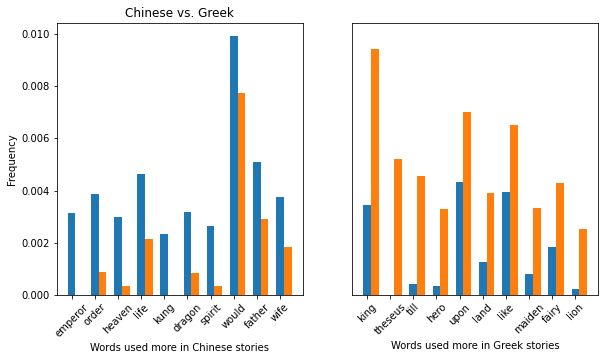

In [8]:
utils.compare_ab(nouns_bynation,'chinese','greek')

*Chinese vs. Greek words.*<br>
In this bar chart, we have the words with the most difference frequency of usage compared between Chinese and Greek culture. Chinese stories are more often about emperors, heaven, dragon, and spirits; while Greek cultures are more often about kings, Theseus, heros, maidens, and fairies.

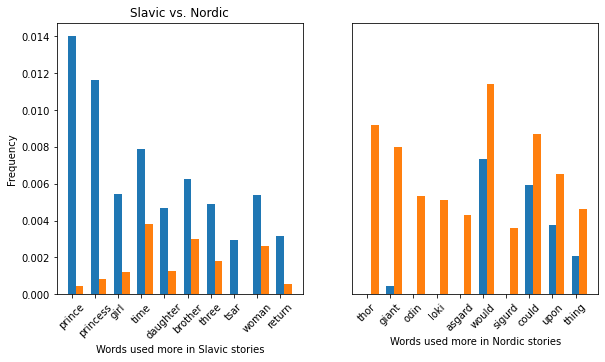

In [9]:
utils.compare_ab(nouns_bynation,'slavic','nordic')

*Slavic vs. Nordic words.*<br>
From this barchart, we see that Slavic stories are more often about royalty, while Nordic stories are more often about their gods.

From these figures, we can see that there's a relationship between the culture and the characters they tell stories about. Like the knight, these characters (general or specific) stand for values. However, we can't directly know what values the culture holds based on their characters. Kings, dragons, and gods are symbols of values, but don't directly tell us what those values are. For that, we'll use linguistic analyses.

However, we can't directly know what values the culture holds based on their characters. Kings, dragons, faries

# Comparison with Hofstede's Dimensions
To interpret this pattern of the relationship between cultural stories and values, I use LIWC word categories and Hofstede's cultural dimension to measure story topics and cultural values.<br>


### Hofstede's dimensions and LIWC
Geert Hofstede's six cultural dimenions are power distance, individualism, masculinity, uncertainty avoidance, long-term orientation, and indulgence. Power distance is the amount people in lower positions of power accept the unequal distribution of power. Individualism is how independent people are, where collectivism is how interdependent communities are. Masculinity is assertiveness, while feminity is caring. Uncertainty avoidance is the intolerance of ambiguity and the unknown. Long-term orientation is the understanding that the world changes, and preperation for the future is good; while short-term orientation is the understanding that the world is today as it was before, so the tradition is good. Indulgence is the access to desires and fun, while restraint is the control of gratification through social norms. Hofstede developed his theory after gaining access to data from a questionnare administered to employees of international programs, where he found differences at the national level. (Hofstede 2007)<br>
<br>
Other studies using Hofstede's dimensions, such as Morling and Lamoreaux, demonstrate a relationship between cultural products (such as advertisements or popular texts) and individualistic and collectivistic psyches as defined by Hofstede (Morling & Lamoreaux 2008). Nation DeWall et al. argue that cultural products can be used to analyze cultural pysche, and they use LIWC to analyze song lyrics (DeWall et al. 2011). While songs are prone to genre changes, folktales are long standing traditions, and are therefore less risk-prone to confounding factors such as genre change. <br>
### Other literature on folktales
I predict that storytelling is related to cultural values because it is a strong teaching tool. Michael Tomasello argues in "The Human Adaptation for Culture" that children cognitively represent the world in uniquely powerful ways. In arguing this, he follows the ontogeny of human cultural learning, of which joint attention and imitative learning are most relevant for us. Join attention is the understanding of the relationship between child, adult, and another entity. An example of a baby of using their join attentional understanding is pointing to a toy to direct the adults attention. This is only possible when they understand other people as intentional agents, who have goals and make active choices to attain goals. After join attention, infants develop the skill of imitative learning. For example, infants were able to learn what a "toma" was after an adult announced her intention to "find the toma", and smiling after it had been found (Tomasello 1999). In relation to stories, children understand characters as intentional agents, who have goals and strategies to achieve goals. Using imitative learning, children can learn those same goals and strategies, such as how to be a good person. <br>
<br>
Many social scientists have theorized about the importance of folktales: <br><br>
JL Fischer analyzes why folktales are a model for society. Rewards and punishments for the supporters/dissenters of society are supplied in audience reaction and events in the folktales. For example, a good hero that suffers a bad fate has its reward in the audience's sympathy rather than the hero's fate, while funny tales where conventions are broken has its punishment in the scorn of the audience. Within tales themselves, dissenters may be punished or heroes rewarded. He then asks whether there is a relationship between folktales and social reality: and he concludes that promiment themes of folktales within a group are often subjects of conflicts (such as the height of chiefs and the smallness of artisans), while not all conflicts are represented in folktales. Additionally, they often overexaggerate (Fischer 1963). Thus, I am validated that the topics of stories should reflect what matters to a society (although maybe not directly!). <br><br>
Additionally, it might be better that stories don't accurately reflect society. Jack Zipes argues that our fondness for folktales across all social classes are because they contain what we lack: "In many ways, fairy tales, with their metaphorical allusions, are more truthful than so-called realistic stories because the tales are generally endowed with a sense of social justice that we do not find in our societies." The morals in stories result from the combination of lower-class storytellers and uppper-class storytellers and writers (Zipes 2019).<br><br>
It has also been argued that the relationship between law and morality makes folktales relevant to legal theory. Alexander Shytov argues that most law is negative, defining what is not allowed, resulting in the divide between laws from morals, because laws have become a mechanism of external coercion rather than a tool of self-governance. Because folktales contain standards of what is right and wrong, it contains the spirit of law, since they represent the moral standards of the whole community, who is the author of these stories (Shytov 2008).
<br> <br>
Thus, it is widely agreed that folktales hold the morals of society, so the words in those folktales should correlate to the values of society.

*Note: Correlation and p-value were calculated using Spearman correlation.*

In [34]:
nation_liwc = pd.read_csv(save_progress+'nation_liwc.csv',index_col=0)
hofstede_cols = ['pdi','idv','mas','uai','ltowvs','ivr']
hofstede_dict = {'pdi':'Power Distance','idv':'Individualism','mas':'Masculinity','uai':'Uncertainty Avoidance','ltowvs':'Long Term Orientation','ivr':'Indulgence'}
liwc_cols = nation_liwc.columns[8:] #http://www.liwc.net/LIWC2007LanguageManual.pdf
nation_liwc = nation_liwc.rename(columns={'nation':'Culture'})
nation_liwc['Culture'] = nation_liwc['Culture'].str.title()

In [8]:
nation_liwc = pd.read_csv(save_progress+'nation_liwc.csv',index_col=0)
hofstede_cols = ['pdi','idv','mas','uai','ltowvs','ivr']
hofstede_dict = {'pdi':'Power Distance','idv':'Individualism','mas':'Masculinity','uai':'Uncertainty Avoidance','ltowvs':'Long Term Orientation','ivr':'Indulgence'}
liwc_cols = nation_liwc.columns[8:] #http://www.liwc.net/LIWC2007LanguageManual.pdf
nation_liwc = nation_liwc.rename(columns={'nation':'Culture'})
nation_liwc['Culture'] = nation_liwc['Culture'].str.title()

In [42]:
corr, plot = utils.compare_liwc_hofstede('pdi',['family','social'],nation_liwc)
corr = corr.set_index('Feature').loc[['family','social']]
corr['Examples'] = ['daughter, husband, aunt','mate, talk, they, child']
corr = corr[['Examples','Correlation','P-Value']]
corr

Examples  Correlation   P-Value
Feature                                                
family   daughter, husband, aunt     0.440543  0.021456
social   mate, talk, they, child     0.417036  0.030453

In [10]:
plot

alt.LayerChart(...)

*Power Distance vs. LIWC.* In this scatterplot, we have the Power Distance Index on the x-axis, and the standardized score of LIWC word categories on the y-axis, with the averages graphed with lines. Power distance is positively correlated to family and social words.

In [44]:
corr, plot = utils.compare_liwc_hofstede('idv',['family','social'],nation_liwc)
corr = corr.set_index('Feature').loc[['family','social']]
corr['Examples'] = ['daughter, husband, aunt','mate, talk, they, child']
corr = corr[['Examples','Correlation','P-Value']]
corr

Examples  Correlation   P-Value
Feature                                                
family   daughter, husband, aunt    -0.409418  0.033947
social   mate, talk, they, child    -0.432962  0.024082

In [12]:
plot

alt.LayerChart(...)

*Individualism vs. LIWC.*<br>
Individualism is negatively correlated to family and social categories. Nations that have a more collective mindset (lower individualism score) use more family and social words, while nations that have a more individualistic mindset huse less family and social words.

In [45]:
corr, plot = utils.compare_liwc_hofstede('uai',['discrep','auxverb'],nation_liwc)
corr = corr.set_index('Feature').loc[['auxverb','discrep']]
corr['Examples'] = ['am, will, have','should, would, could']
corr = corr[['Examples','Correlation','P-Value']]
corr

Examples  Correlation   P-Value
Feature                                             
auxverb        am, will, have     -0.42229  0.028217
discrep  should, would, could     -0.54229  0.003476

In [14]:
plot

alt.LayerChart(...)

*Uncertainty Avoidance vs. LIWC.*<br>
Nations that have are less avoidant of uncertainty use more auxverbs (eg. am, will, have) and discrep words (eg. should, would, could). Since nations with a higher uncertainty avoidance are more stressed about unknown futures, this is not what I expected.

In [46]:
corr, plot = utils.compare_liwc_hofstede('mas',['sexual','health'],nation_liwc)
corr = corr.set_index('Feature').loc[['health','sexual']]
corr['Examples'] = ['clinic, flu, pill','horny, love, incest']
corr = corr[['Examples','Correlation','P-Value']]
corr

Examples  Correlation   P-Value
Feature                                            
health     clinic, flu, pill     0.416247  0.030801
sexual   horny, love, incest     0.419301  0.029472

In [16]:
plot

alt.LayerChart(...)

*Masculinity vs. LIWC.*<br>
There is a positive correlation between masculinity (assertiveness) and words related to health (eg. clinic, flu, pill) and sexual (eg. horny, love, incest).

In [49]:
corr, plot = utils.compare_liwc_hofstede('ltowvs',['discrep'],nation_liwc)
corr = corr.set_index('Feature').loc[['discrep']]
corr['Examples'] = ['should, would, could']
corr = corr[['Examples','Correlation','P-Value']]
corr

Examples  Correlation   P-Value
Feature                                             
discrep  should, would, could    -0.409035  0.034131

In [18]:
plot

alt.LayerChart(...)

*Long Term Orientation vs. LIWC.*<br>
There is a negative correlation between a long term orientation and the use of discrep words (eg. should, would, could). 

In [51]:
corr, plot = utils.compare_liwc_hofstede('ivr',['home','family'],nation_liwc)
corr = corr.set_index('Feature').loc[['family','home']]
corr['Examples'] = ['daughter, husband, aunt','apartment, kitchen, family']
corr = corr[['Examples','Correlation','P-Value']]
corr

Examples  Correlation   P-Value
Feature                                                   
family      daughter, husband, aunt    -0.535878  0.003965
home     apartment, kitchen, family     0.432977  0.024077

In [20]:
plot

alt.LayerChart(...)

*Indulgence vs. LIWC.* There is a negative correlation between indulgence and home words, and a positive correlation between indulgence and family words.

## Conclusion

Overall, I found that there are many correlations between the words used in the folktales of a nation and the nation's values. Power distance is positively related to family and social, while individualism is negatively related to family and social.  Family likely contributes to the correlation seen with social. Family's positive correlation to power distance shows that families are a large institution where less powerful members accept their position. Thus, nations that tell more stories about families value families more, and accept their position of power more.Family's negative association with individualism is due to the importance of families in community and interdependent lifestyles. Uncertainty avoidance is negatively related to auxverbs and discrep words. This is opposite of what I expected: since nations with a higher uncertainty avoidance are more stressed about an unknown future, I would have expected that they use more certain words in relation to the future (discrep words -- should, would, could). Masculinity is positively related to health and sexual words. Since Hofstede defined masculinity using a traditional understanding of masculinity as assertive, the health component likely comes from the similarity of assertive qualities and strong qualities. The sexual component is likely due to the ideal of a man having a love interest. Long term orientation is positively related to indulgence and family words. Since short term orientation (confusingly!) refers to a strong respect for tradition, the long term oriented cultures having more indulgence words agrees with my expectation. <br>
<br>
Thus, we see that folktales do often reflect cultural values. Storytelling is an important way to communicate values. While folktales reflect long-standing values, other stories might be able to reveal other values of society: the way Frankenstein came out at a time galvanization was popular, or our current stories about AI.

[GitHub link](https://github.com/graceshaoy/folktales)

## Bibliography

DeWall, C.N., Pond, R.S., Jr., Campbell, W.K. & Twenge, J.M. (2011). "Tuning in to Psychological Change: Linguistic Markers of Psychological Traits and Emotions Over Time in Popular U.S. Song Lyrics" Psychology of Aesthetics, Creativity, and the Arts. doi: 10.1037/a0023195<br><br>
Fischer, J.L. (1963). "The Sociopsychological Analysis of Folktales" *Current Anthropology 4(3)* 233-336. https://doi.org/10.1086/20037<br><br>
Hofstede, G. (2011). "Dimensionalizing Cultures: The Hofstede Model in Context" *Online Readings in Psychology and Culture, Unit 2*. https://scholarworks.gvsu.edu/orpc/vol2/iss1/8/<br><br>
Morling, B., & Lamoreaux, M. (2008). "Measuring Culture Outside the Head: A Meta-Analysis of Individualism--Collectivism in Cultural Products" *Personality and Social Psychology Reivew, 12(3)*, 199-221. https://doi.org/10.1177/1088868308318260<br><br>
Pennebaker, J.W., Chung, C.K. (2011). "Linguistic Inquiry and Word Count (LIWC): Pronounced 'Luke'... and Other Useful Facts" *Applied Natural Language Processing: Identification, Investigation, and Resolution.* edited by McCarthy, Philip M. and Chutima Boonthum-Denecke, 206-229. https://doi.org/10.4018/978-1-60960-741-8.ch012<br><br>
Shytov, A., Mai, C. (2008). "Folktales as the Source of Law" *Archives for Philosophy of Law and Social Philosophy 94(3)* 325-336. https://www.jstor.org/stable/23680880<br><br>
Tomasello, M. (1999). "The Human Adaptation for Culture" *Annual Review of Anthropology 28*, 509-529. https://www.jstor.org/stable/223404<br><br>
Zipes, J. (2019). "Speaking the Truth with Folk and Fairy Tales: The Power of the Powerless." *The Journal of American Folklore 132(525)* 243–59. https://doi.org/10.5406/jamerfolk.132.525.0243.